# **Project: Aligning SmolLM-135M for Grammatical Error Correction**
This notebook documents the process of fine-tuning and aligning a small language model for a GEC task. We start with a strong Supervised Fine-Tuning (SFT) baseline and then explore two preference optimization techniques, DPO and GRPO, to further refine the model's performance.

### **Table of Contents**
1. [Objective](#objective)
2. [Setup & Utilities](#setup)
3. [Data Loading & Preparation](#data)
4. [Load Base Model & Get Zero-Shot Baseline](#base)
5. [Supervised Fine-Tuning (SFT) - The Baseline](#sft)
6. [Direct Preference Optimization (DPO)](#dpo)
7. [Group Reward Preference Optimization (GRPO)](#grpo)
8. [Final Results & Comparison](#final-results)
9. [Conclusion](#conclusion)
10. [Appendix](#appendix)

<a id='objective'></a>
### **🎯 Objective**
The goal is to systematically evaluate the impact of different alignment strategies on `SmolLM-135M` for grammatical error correction. I compare:
1.  **SFT (Supervised Fine-Tuning):** Our baseline for task-specific learning.
2.  **DPO (Direct Preference Optimization):** Refining the SFT model using preference pairs.
3.  **GRPO (Group Reward Preference Optimization):** Refining the SFT model using a reward-based, online training approach.

I use [**`HuggingFaceTB/SmolLM-135M`**](https://huggingface.co/HuggingFaceTB/SmolLM-135M) as the base model. Its small size makes it ideal for rapid experimentation and efficient fine-tuning, testing multiple alignment strategies with low computational costs.

<a id='setup'></a>
### **🛠️ Setup**
This section contains all necessary imports, utility functions (`CheckpointManager`, `get_or_evaluate_score`, etc.), and initial configuration.

In [1]:
# Core imports
import torch
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import gc
from pathlib import Path
from tqdm import tqdm
import datetime


# Hugging Face ecosystem
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from trl import SFTTrainer, DPOTrainer, DPOConfig, GRPOTrainer, GRPOConfig

# Evaluation
import evaluate

# For GRPO reward function
from fast_edit_distance import edit_distance


print("✅ All imports successful!")


✅ All imports successful!


#### Evaluation Function

BLEU (Bilingual Evaluation Understudy) Score:
- Measures n-gram overlap between prediction and reference
- Range: 0.0 to 1.0 (higher is better)
- Standard metric for text generation tasks

In [2]:
def evaluate_model(model, tokenizer, ds):
    """
    Evaluates model by generating predictions and calculating BLEU score.

    Args:
        model: The language model to evaluate
        tokenizer: Tokenizer for the model
        ds: Dataset containing src/tgt examples

    Returns:
        float: BLEU score (0.0 to 1.0)
    """
    model.eval()
    preds = []
    targets = []

    print(f"Evaluating on {len(ds)} examples...")

    for example in tqdm(ds, desc="Generating predictions"):
        # Ground truth
        targets.append([example['tgt']])

        # Format prompt
        prompt = format_text(example['src'])

        # Generate prediction
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        prompt_len = inputs["input_ids"].shape[1]

        with torch.no_grad():
            gen = model.generate(
                **inputs,
                max_new_tokens=128,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=False,
            )

        # Decode (remove prompt)
        prediction = tokenizer.decode(gen[0][prompt_len:], skip_special_tokens=True)
        preds.append(prediction)

    # Calculate BLEU
    bleu = evaluate.load("bleu")
    results = bleu.compute(predictions=preds, references=targets)

    return results["bleu"]

print("✅ Evaluation function defined")

✅ Evaluation function defined


#### Checkpoint Utilities
- see [appendix](#appendix) for more details

In [3]:
# ============================================================
# CHECKPOINT UTILITIES
# ============================================================

class CheckpointManager:
    """Manages scores and metadata in a JSON file."""
    def __init__(self, scores_file="bleu_scores.json"):
        self.scores_file = Path(scores_file)

    def save_score(self, method: str, score_data: dict):
        """Save a dictionary of score data."""
        scores = self.load_all_scores()
        scores[method] = score_data
        with open(self.scores_file, 'w') as f:
            json.dump(scores, f, indent=4)
        print(f"💾 Saved {method} score to {self.scores_file}")

    def load_score_data(self, method: str):
        """Load the entire data packet for a method."""
        scores = self.load_all_scores()
        return scores.get(method)

    def load_all_scores(self):
        """Load all saved scores."""
        if not self.scores_file.exists():
            return {}
        with open(self.scores_file, 'r') as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                return {} # Handle case where file is empty or corrupt

def get_or_evaluate_score(
    method: str, 
    model_path: str, # <-- New argument to track the model version
    model, 
    tokenizer, 
    test_dataset, 
    evaluate_fn, 
    force_eval=False
):
    """
    Get a score from cache or evaluate it. The cache is only used if the
    model_path matches the one stored in the cache.
    """
    manager = CheckpointManager()
    cached_data = None if force_eval else manager.load_score_data(method)

    # Check if cache is valid: exists AND model paths match
    if cached_data and cached_data.get("model_path") == model_path:
        score = cached_data["score"]
        print(f"✅ Loaded saved {method} score: {score:.4f} (from model: {model_path})")
    else:
        print(f"🔍 Evaluating {method} for model: {model_path}...")
        if cached_data:
            print(f"   (Cache invalid: path mismatch or force_eval=True)")

        score = evaluate_fn(model, tokenizer, test_dataset)
        
        # Save score along with metadata
        score_data = {
            "score": score,
            "model_path": model_path,
            "timestamp": datetime.datetime.now().isoformat()
        }
        manager.save_score(method, score_data)
        print(f"✅ {method} new score: {score:.4f}")

    return score

<a id='data'></a>
### **📂 Part 1: Data Loading & Preparation**
Loading the `grammarly/coedit` dataset and filter it for the "gec" (Grammatical Error Correction) task. The data is then formatted into a prompt-completion structure suitable for training.

In [4]:
print("☁️ Loading dataset: grammarly/coedit (will use cache if available)")

# This single line handles everything:
# 1. Downloads the data on the first run.
# 2. Saves it to a central cache (~/.cache/huggingface/datasets).
# 3. Instantly loads from the cache on all subsequent runs.
dataset = load_dataset("grammarly/coedit")

# Filter for grammatical error correction using the library's efficient method
train_gec = dataset['train'].filter(lambda x: x['task'] == 'gec')
test_gec = dataset['validation'].filter(lambda x: x['task'] == 'gec')

print(f"\n✅ Dataset loaded:")
print(f"  Train: {len(train_gec)} examples")
print(f"  Test:  {len(test_gec)} examples")

# Show example
print(f"\nExample:")
print(f"  Source: {train_gec[0]['src']}")
print(f"  Target: {train_gec[0]['tgt']}")

☁️ Loading dataset: grammarly/coedit (will use cache if available)

✅ Dataset loaded:
  Train: 19823 examples
  Test:  485 examples

Example:
  Source: Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.
  Target: For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.


In [6]:
def format_text(text: str) -> str:
    """Format input for inference (matches training format)."""
    return f"Fix grammatically: {text}\n\nCorrected: "

def format_for_training(example):
    """Format example for SFT training."""
    prompt = f"Fix grammatically: {example['src']}\n\nCorrected: "
    completion = f"{example['tgt']}{tokenizer.eos_token}"
    return {"text": prompt + completion}

# Apply formatting to training data
train_formatted = train_gec.map(format_for_training)

print("Example formatted:")
print(train_formatted[0]['text'])

Example formatted:
Fix grammatically: Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.

Corrected: For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.<|endoftext|>


<a id='base'></a>
### **✅ Part 2: Load Base Model & Get Zero-Shot Baseline**

**Model**: `HuggingFaceTB/SmolLM-135M` - Small, efficient language model selected for rapid experimentation.

In [7]:
# ============================================================
# PART 2: LOAD BASE MODEL & GET ZERO-SHOT BASELINE
# ============================================================
print("\n" + "="*70)
print("Loading Base Model & Running Zero-Shot Evaluation")
print("="*70)

# --- 1. Load Base Model and Tokenizer from Hub ---
base_model_name = "HuggingFaceTB/SmolLM-135M"

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# --- 2. Apply the Definitive Pad Token Fix ---
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id
print("✅ Base model and tokenizer loaded and configured.")

# --- 3. Run Zero-Shot Evaluation ---
# This will get the baseline score before any training
zero_shot_bleu = get_or_evaluate_score(
    method="zero_shot_bleu",
    model_path=base_model_name,
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_gec,
    evaluate_fn=evaluate_model,
)
print(f"\n✅ Zero-Shot (Base Model) BLEU Score: {zero_shot_bleu:.4f}")



Loading Base Model & Running Zero-Shot Evaluation
✅ Base model and tokenizer loaded and configured.
🔍 Evaluating zero_shot_bleu for model: HuggingFaceTB/SmolLM-135M...
Evaluating on 485 examples...


Generating predictions: 100%|██████████| 485/485 [40:12<00:00,  4.97s/it]


💾 Saved zero_shot_bleu score to bleu_scores.json
✅ zero_shot_bleu new score: 0.1501

✅ Zero-Shot (Base Model) BLEU Score: 0.1501


In [6]:

output_dir="./models/sft"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    # model is learning a new task, so higher lr to start
    learning_rate=2e-4,
    logging_steps=25,
    save_steps=100,
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=3,
    bf16=True,
    report_to="none",
)


Loading base model, setting up fine tune training
\n📦 Loading base model HuggingFaceTB/SmolLM-135M...


<a id='sft'></a>
### **✅ Part 3: Supervised Fine-Tuning (SFT)**

Now that with a baseline score, I fine-tune the base model on the GEC dataset. I train for several epochs with early stopping to capture the best performance before overfitting occurs.

**Key technique**: Completion-only loss (Handled automatically by `SFTTrainer` when `dataset_text_field` is specified).

In [11]:
print("="*70)
print("PART 1: SUPERVISED FINE-TUNING (SFT)")
print("="*70)


# Format test dataset for evaluation
test_formatted = test_gec.map(format_for_training)

# Create trainer
# TRL 0.23.1+ simplified API - just pass model, args, and datasets
sft_trainer = SFTTrainer(
    model=sft_model,
    args=training_args,
    train_dataset=train_formatted,
    eval_dataset=test_formatted,
)

print("\n🚀 Starting SFT training...")
sft_trainer.train()

print("\n✅ SFT training complete!")

final_sft_path = "./models/sft_final"
sft_trainer.save_model(final_sft_path)
print(f"\n✅ Final SFT model saved to {final_sft_path}")

PART 1: SUPERVISED FINE-TUNING (SFT)


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19823 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.



🚀 Starting SFT training...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
100,1.499600,2.506608,2.127586,186801.000000,0.552453
200,1.484700,2.496941,2.098597,374314.000000,0.554280
300,1.440000,2.488280,2.080165,563173.000000,0.554871
400,1.465100,2.485803,2.094685,754049.000000,0.554624
500,1.455500,2.473471,2.102146,942335.000000,0.557375
600,1.446400,2.479551,2.077553,1130280.000000,0.556708
700,1.407100,2.479375,2.057276,1317364.000000,0.557751
800,1.396200,2.485267,2.003959,1506119.000000,0.553327
900,1.412800,2.480044,2.028492,1694059.000000,0.557500
1000,1.406000,2.480583,2.021108,1881351.000000,0.558415


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✅ SFT training complete!

✅ Final SFT model saved to ./models/sft_final


#### **SFT Analysis: Quick Overfitting**
The training and validation loss curves below show that the model learns the task very quickly but also begins to overfit early on (around step 500). This is expected for a small model on a focused task and confirms that our early stopping strategy was essential to capture the model at its peak performance.


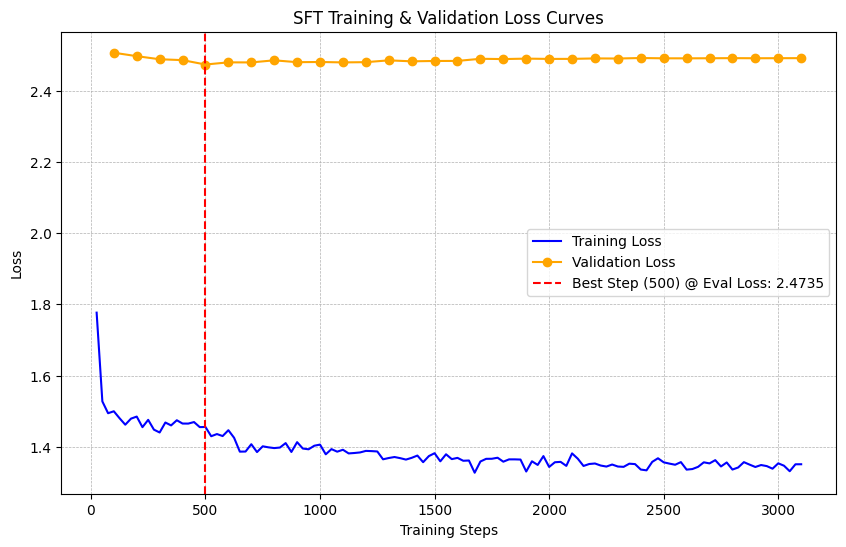

In [13]:
log_history = sft_trainer.state.log_history

# Use pandas to easily parse the log history
df = pd.DataFrame(log_history)

# Separate training and evaluation logs
train_logs = df[df['loss'].notna()].copy()
eval_logs = df[df['eval_loss'].notna()].copy()

# Find the best step
best_step = eval_logs.loc[eval_logs['eval_loss'].idxmin()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss', color='blue')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', color='orange', marker='o')

# Highlight the best step
plt.axvline(x=best_step['step'], color='red', linestyle='--', 
            label=f"Best Step ({int(best_step['step'])}) @ Eval Loss: {best_step['eval_loss']:.4f}")

plt.title('SFT Training & Validation Loss Curves')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [7]:
# ============================================================
# STAGE 2: EVALUATE SFT MODEL & PREPARE FOR PREFERENCE TUNING
# ============================================================
print("\n" + "="*70)
print("LOADING FINAL SFT MODEL FOR EVALUATION")
print("="*70)

# 1. Load the model and tokenizer from your final SFT output directory
final_sft_path = "./models/sft_final"
sft_model = AutoModelForCausalLM.from_pretrained(final_sft_path)
tokenizer = AutoTokenizer.from_pretrained(final_sft_path)


# A) Configure the tokenizer object itself
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# B) Configure the model's main config
sft_model.config.pad_token_id = tokenizer.pad_token_id

# C) Configure the model's generation config
sft_model.generation_config.pad_token_id = tokenizer.pad_token_id


# 3. Now, move to GPU and run your evaluation
if torch.cuda.is_available():
    sft_model.to("cuda")

print(f"✅ Successfully loaded final SFT model from {final_sft_path}")



LOADING FINAL SFT MODEL FOR EVALUATION
✅ Successfully loaded final SFT model from ./models/sft_final


In [25]:

sft_bleu = get_or_evaluate_score(
    method="sft_bleu",
    model_path=final_sft_path, # Pass the model path here
    model=sft_model,
    tokenizer=tokenizer,
    test_dataset=test_gec,
    evaluate_fn=evaluate_model,
    force_eval=False,
)

print(f"\n✅ Final SFT BLEU Score: {sft_bleu:.4f}")
print("="*70)

# Now, sft_model is ready to be used to generate your DPO/GRPO dataset,
# or to be passed as the initial model to your DPOTrainer/GRPOTrainer.


LOADING FINAL SFT MODEL FOR EVALUATION
✅ Successfully loaded final SFT model from ./models/sft_final
🔍 Evaluating sft_bleu for model: ./models/sft_final...
Evaluating on 485 examples...


Generating predictions: 100%|██████████| 485/485 [19:27<00:00,  2.41s/it]


💾 Saved sft_bleu score to bleu_scores.json
✅ sft_bleu new score: 0.4590

✅ Final SFT BLEU Score: 0.4590


### **🧠 Part 4: Refining with Preference Optimization (DPO & GRPO)**
While SFT is effective, it only teaches the model to mimic a single ground truth. Preference optimization techniques like DPO and GRPO can teach the model more nuanced concepts of "quality" by showing it which of several possible answers is "better."

<a id='dpo'></a>
#### **DPO: Direct Preference Optimization**
For DPO, I first generate a dataset of `(prompt, chosen, rejected)` triplets then use the SFT model to generate two variants for each prompt and label them based on their edit distance to the ground truth. Then the model is trained to prefer the "chosen" responses.

**Key hyperparameter**: `beta` - controls KL divergence penalty (how much model can change)

⚠️ **Prerequisite:** Before running the following cell, make sure you have successfully loaded your best-performing SFT model into a variable named `sft_model` and its corresponding tokenizer into a variable named `tokenizer`. This cell will use that model to generate the preference pairs.


In [26]:
print("="*70)
print("PART 2: CREATE DPO PREFERENCE DATASET")
print("="*70)

dpo_dataset_path = "./datasets/dpo_dataset"

# Check if the dataset has already been generated and saved
if os.path.exists(dpo_dataset_path):
    print(f"💾 Loading existing DPO dataset from {dpo_dataset_path}...")
    dpo_dataset = load_from_disk(dpo_dataset_path)

else:
    print("⏳ DPO dataset not found. Generating new dataset...")
    # This block will only run if the dataset doesn't exist on disk
    
    preference_size = 1000
    preference_data = train_gec.shuffle(seed=42).select(range(preference_size))
    print(f"Generating preferences for {len(preference_data)} examples...")

    dpo_data_list = []
    distance_stats = []

    # Use the loaded SFT model for generation
    sft_model.eval()

    for example in tqdm(preference_data, desc="Generating DPO pairs"):
        prompt = format_text(example['src'])
        inputs = tokenizer(prompt, return_tensors="pt").to(sft_model.device)
        prompt_len = inputs["input_ids"].shape[1]

        # Generate two variants with different temperatures
        with torch.no_grad():
            gen_a = sft_model.generate(
                **inputs, max_new_tokens=128, temperature=0.7, do_sample=True,
                eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id
            )
            gen_b = sft_model.generate(
                **inputs, max_new_tokens=128, temperature=1.2, do_sample=True,
                eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id
            )

        text_a = tokenizer.decode(gen_a[0][prompt_len:], skip_special_tokens=True)
        text_b = tokenizer.decode(gen_b[0][prompt_len:], skip_special_tokens=True)

        # Skip if identical
        if text_a == text_b:
            continue

        dist_a = edit_distance(text_a, example['tgt'])
        dist_b = edit_distance(text_b, example['tgt'])
        
        # Only keep pairs where one is clearly better (distance diff >= 2)
        if abs(dist_a - dist_b) < 2:
            continue

        # Label chosen/rejected
        if dist_a < dist_b:
            chosen, rejected = text_a, text_b
        else:
            chosen, rejected = text_b, text_a

        dpo_data_list.append({
            "prompt": prompt,
            "chosen": chosen,
            "rejected": rejected,
        })

    dpo_dataset = Dataset.from_list(dpo_data_list)

    # Save the newly created dataset
    dpo_dataset.save_to_disk(dpo_dataset_path)
    print(f"\n💾 DPO dataset generated and saved to {dpo_dataset_path}")

# This part will run regardless of whether the data was loaded or generated
print("\n" + "="*50)
print("DPO Dataset Summary")
print(f"✅ DPO dataset ready with {len(dpo_dataset)} preference pairs.")
print(f"  Example Prompt: {dpo_dataset[0]['prompt'][:80]}...")
print(f"  Example Chosen: {dpo_dataset[0]['chosen']}")
print(f"  Example Rejected: {dpo_dataset[0]['rejected']}")
print("="*70)

PART 2: CREATE DPO PREFERENCE DATASET
⏳ DPO dataset not found. Generating new dataset...
Generating preferences for 1000 examples...


Generating DPO pairs: 100%|██████████| 1000/1000 [36:22<00:00,  2.18s/it]


Saving the dataset (0/1 shards):   0%|          | 0/906 [00:00<?, ? examples/s]


💾 DPO dataset generated and saved to ./datasets/dpo_dataset

DPO Dataset Summary
✅ DPO dataset ready with 906 preference pairs.
  Example Prompt: Fix grammatically: Fix grammar errors in this sentence: Finally, scientists hypo...
  Example Chosen:  Finally, scientists hypothesize that our brains are helpful enough when we can help others.
  Example Rejected:  After that, scientists hypothesize that our brains are helpful enough when helping other people.


In [28]:
distance_stats_path = './models/dpo/distance_stats.json'

if os.path.exists(distance_stats_path):
    print(f"💾 Loading existing distance_stats from {distance_stats_path}...")
    with open(distance_stats_path, 'r') as f:
        distance_stats = json.load(f)
else:
    # This assumes distance_stats was just generated in the previous cell
    print(f"💾 Saving new distance_stats to {distance_stats_path}...")
    with open(distance_stats_path, 'w') as f:
        json.dump(distance_stats, f)


# Print distance statistics
import numpy as np
diffs = [s['distance_diff'] for s in distance_stats]
print(f"\n✅ Created DPO dataset with {len(dpo_dataset)} preference pairs")
print(f"\n📊 Distance Statistics:")
print(f"   Total generated: {len(distance_stats)} pairs")
print(f"   Kept (diff >= 2): {len(dpo_dataset)} pairs ({len(dpo_dataset)/len(distance_stats)*100:.1f}%)")
print(f"   Distance diff - Mean: {np.mean(diffs):.2f}, Median: {np.median(diffs):.2f}, Max: {np.max(diffs):.0f}")

print(f"\nExample:")
print(f"  Prompt: {dpo_dataset[0]['prompt'][:50]}...")
print(f"  Chosen: {dpo_dataset[0]['chosen'][:50]}...")
print(f"  Rejected: {dpo_dataset[0]['rejected'][:50]}...")

💾 Loading existing distance_stats from ./models/dpo/distance_stats.json...

✅ Created DPO dataset with 906 preference pairs

📊 Distance Statistics:
   Total generated: 483 pairs
   Kept (diff >= 2): 906 pairs (187.6%)
   Distance diff - Mean: 29.57, Median: 16.00, Max: 306

Example:
  Prompt: Fix grammatically: Fix grammar errors in this sent...
  Chosen:  Finally, scientists hypothesize that our brains a...
  Rejected:  After that, scientists hypothesize that our brain...


/tmp/ipykernel_6981/142262105.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([dist_a_list, dist_b_list], labels=['Variant A (0.7)', 'Variant B (1.2)'])


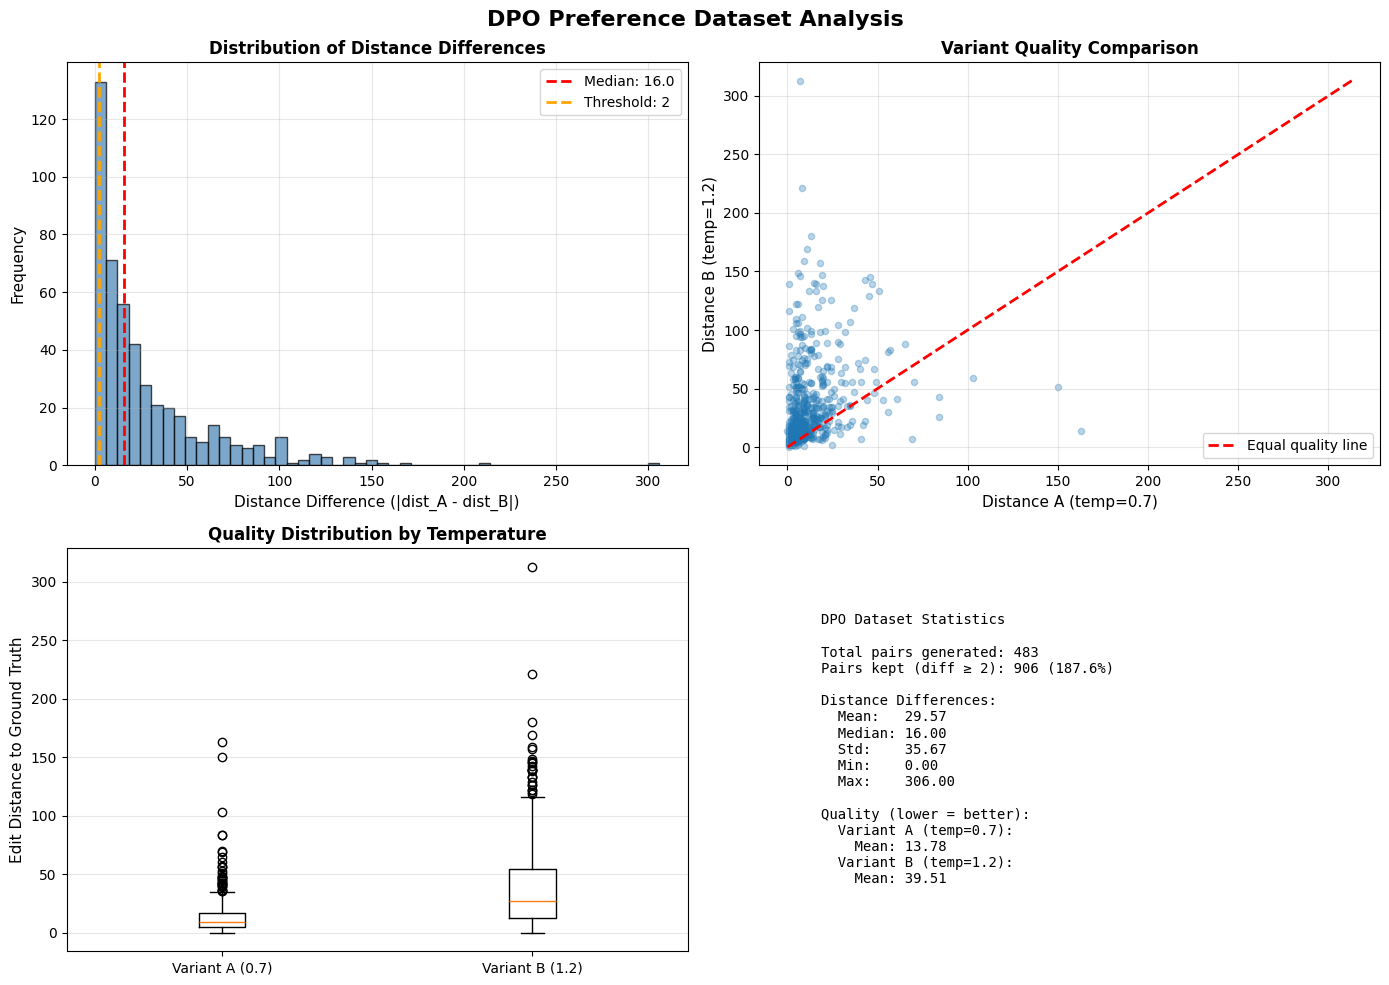


📊 Distance analysis saved to 'dpo_distance_analysis.png'
cp: cannot create regular file '/content/drive/MyDrive/preference_optimization_models/': No such file or directory
✅ Saved to Google Drive!


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:

# ============================================================
# ANALYZE DPO DISTANCE DISTRIBUTION
# ============================================================

# Extract distance differences
diffs = [s['distance_diff'] for s in distance_stats]
dist_a_list = [s['dist_a'] for s in distance_stats]
dist_b_list = [s['dist_b'] for s in distance_stats]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('DPO Preference Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Histogram of distance differences
axes[0, 0].hist(diffs, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(np.median(diffs), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(diffs):.1f}')
axes[0, 0].axvline(2, color='orange', linestyle='--', linewidth=2, label='Threshold: 2')
axes[0, 0].set_xlabel('Distance Difference (|dist_A - dist_B|)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Distance Differences', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter: dist_A vs dist_B
axes[0, 1].scatter(dist_a_list, dist_b_list, alpha=0.3, s=20)
axes[0, 1].plot([0, max(dist_a_list + dist_b_list)], [0, max(dist_a_list + dist_b_list)],
                'r--', linewidth=2, label='Equal quality line')
axes[0, 1].set_xlabel('Distance A (temp=0.7)', fontsize=11)
axes[0, 1].set_ylabel('Distance B (temp=1.2)', fontsize=11)
axes[0, 1].set_title('Variant Quality Comparison', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot
axes[1, 0].boxplot([dist_a_list, dist_b_list], labels=['Variant A (0.7)', 'Variant B (1.2)'])
axes[1, 0].set_ylabel('Edit Distance to Ground Truth', fontsize=11)
axes[1, 0].set_title('Quality Distribution by Temperature', fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Statistics summary
stats_text = f"""
DPO Dataset Statistics

Total pairs generated: {len(distance_stats)}
Pairs kept (diff ≥ 2): {len(dpo_dataset)} ({len(dpo_dataset)/len(distance_stats)*100:.1f}%)

Distance Differences:
  Mean:   {np.mean(diffs):.2f}
  Median: {np.median(diffs):.2f}
  Std:    {np.std(diffs):.2f}
  Min:    {np.min(diffs):.2f}
  Max:    {np.max(diffs):.2f}

Quality (lower = better):
  Variant A (temp=0.7):
    Mean: {np.mean(dist_a_list):.2f}
  Variant B (temp=1.2):
    Mean: {np.mean(dist_b_list):.2f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('dpo_distance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Distance analysis saved to 'dpo_distance_analysis.png'")

# Save to Drive
!cp dpo_distance_analysis.png /content/drive/MyDrive/preference_optimization_models/
print("✅ Saved to Google Drive!")

#### **DPO: Analyzing the Preference Pairs**

Before training the DPO model, I analyzed the preference pairs generated. The plots visualize the distribution of edit distances between the two variants (one from a low-temperature setting, one from a higher-temperature setting).
1.  The generation strategy successfully created diverse pairs with a meaningful quality difference.
2.  The filtering threshold (keeping only pairs with an edit distance difference of 2 or more) effectively removes noisy, low-signal pairs while retaining a high-quality dataset for efficient training.

In [50]:
# ============================================================
# PART 3: PREPARE AND TRAIN WITH DPO
# ============================================================
print("\n" + "="*70)
print("PREPARING FOR DPO TRAINING")
print("="*70)
torch.cuda.empty_cache()
# 1. Load your final SFT model and tokenizer
sft_model_path = "./models/sft_final"
sft_model = AutoModelForCausalLM.from_pretrained(sft_model_path)
tokenizer = AutoTokenizer.from_pretrained(sft_model_path)
print(f"✅ Loaded base model for DPO from {sft_model_path}")

print("🔧 Configuring padding tokens for DPO training...")
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

sft_model.config.pad_token_id = tokenizer.pad_token_id
if hasattr(sft_model, 'generation_config'):
  sft_model.generation_config.pad_token_id = tokenizer.pad_token_id

# DPO config 
dpo_config = DPOConfig(
    output_dir="./models/dpo_training",
    beta=0.1,
    learning_rate=5e-6, #smaller lr as most likely just needs nudge using the already fine tuned model
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    logging_steps=50,
    eval_strategy="no",
    save_strategy="steps", 
    bf16=True,
    report_to="none",
)

# 3. Initialize the DPOTrainer
dpo_trainer = DPOTrainer(
    model=sft_model,     
    ref_model=None,       # Let TRL handle the reference model
    args=dpo_config,
    train_dataset=dpo_dataset,
)

# 4. Start Training
print("\n🚀 Starting DPO training...")
dpo_trainer.train()
print("\n✅ DPO training complete!")


PREPARING FOR DPO TRAINING
✅ Loaded base model for DPO from ./models/sft_final
🔧 Configuring padding tokens for DPO training...


Extracting prompt in train dataset:   0%|          | 0/906 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/906 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/906 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.



🚀 Starting DPO training...


Step,Training Loss
50,0.652600
100,0.440200
150,0.267800
200,0.307300
250,0.232500
300,0.259100
350,0.302400
400,0.229500
450,0.239000
500,0.240400



✅ DPO training complete!



#### **DPO: Direct Preference Optimization**

After training on these pairs, the final BLEU score did not show an improvement over the SFT baseline. This is an expected outcome that highlights the limitations of automated metrics; DPO optimizes for a nuanced preference signal, not just similarity to a single reference, and its true impact is often better seen in a qualitative analysis.

In [63]:
# ============================================================
# PART 4: EVALUATING AND SAVING THE DPO MODEL
# ============================================================
print("\n" + "="*70)
print("EVALUATING DPO MODEL")
print("="*70)

# Note: The final trained model is in dpo_trainer.model
# We can use it directly for evaluation.

final_dpo_path = "./models/dpo_final"

dpo_bleu = get_or_evaluate_score(
    method="dpo_bleu",
    model_path=final_dpo_path, # Use the final path for metadata
    model=dpo_trainer.model,
    tokenizer=tokenizer,
    test_dataset=test_gec,
    evaluate_fn=evaluate_model,
    force_eval=True, # Force evaluation for this new model
)

print(f"\n✅ Final DPO BLEU Score: {dpo_bleu:.4f}")

# Optional: You can now load the SFT score and compare
sft_bleu = CheckpointManager().load_score_data("sft_bleu")["score"]
improvement = dpo_bleu - sft_bleu
print(f"   Improvement over SFT: {improvement:+.4f}")
print("="*70)

dpo_trainer.save_model(final_dpo_path)
# ALSO explicitly save the tokenizer to the same directory
tokenizer.save_pretrained(final_dpo_path)

print(f"✅ DPO model AND tokenizer saved to {final_dpo_path}")

   Improvement over SFT: -0.0006
✅ DPO model AND tokenizer saved to ./models/dpo_final


#### **GRPO: Group Reward Preference Optimization Experiments**
For GRPO, I ran a series of experiments to find the best hyperparameters. I varied the "group size" (`num_completions`) to see how it impacts performance. This is done in an "online" fashion, where the model generates completions and receives rewards during the training loop.

**Why it's powerful**:
- More sample-efficient than DPO
- Captures fine-grained quality differences
- No need for labeled preferences - just a reward function

<a id='grpo'></a>
### **GRPO: Pushing the Limit with 16 Completions**

Our initial experiments showed a clear trend: increasing the group size from 4 to 12 resulted in a better BLEU score. The performance gain was strongest when moving from 8 to 12, suggesting we hadn't yet reached the point of diminishing returns.

To test this theory, we'll run one final experiment with a group size of 16 to see if this trend continues or if performance begins to plateau.

In [41]:

# ============================================================
# GRPO EXPERIMENTS: COMPARE GROUP SIZES
# ============================================================

print("="*70)
print("GRPO GROUP SIZE EXPERIMENTS")
print("="*70)

# Prepare dataset
def create_prompt_only(example):
  """Formats the source text into a prompt for the model."""
  return {"prompt": f"Fix grammatically: {example['src']}\n\nCorrected: "}

# Create prompt dataset
prompt_dataset = train_gec.map(create_prompt_only)

# Use subset for experiments (1000 examples for better signal)
experiment_size = 1000
train_data = prompt_dataset.shuffle(seed=43).select(range(experiment_size))
train_data = train_data.select_columns(["prompt", "tgt"])

print(f"📁 Prepared {len(train_data)} examples for experiments")

# Reward functions
def format_reward_func(completions: list[str], **kwargs) -> list[float]:
  """Simple format check - penalize empty completions."""
  rewards = []
  for comp in completions:
      if len(comp.strip()) > 5:
          rewards.append(0.1)
      else:
          rewards.append(-0.1)
  return rewards

def correctness_reward_func(completions: list[str], **kwargs) -> list[float]:
  """Main reward - edit distance to ground truth."""
  rewards = []

  # Get ground truths - kwargs contains the batch
  if "tgt" in kwargs:
      ground_truths = kwargs["tgt"]
  else:
      ground_truths = [kwargs.get("tgt", "")]

  for i, comp in enumerate(completions):
      if i < len(ground_truths):
          gt = ground_truths[i] if isinstance(ground_truths, list) else ground_truths
          distance = edit_distance(comp.strip(), gt.strip())
          reward = 1.0 / (1.0 + float(distance))
          rewards.append(reward)
      else:
          rewards.append(0.0)

  return rewards

# Define experiments
experiments = [
    {"num_completions": 4, "run_name": "grpo_completions_4"},
    {"num_completions": 8, "run_name": "grpo_completions_8"},
    {"num_completions": 12, "run_name": "grpo_completions_12"},
    {"num_completions": 16, "run_name": "grpo_completions_16"},
]

# ✅ FIX: Use the correct path that actually exists!
sft_model_path = "./models/sft_final"

# Storage for results
all_run_logs = {}
manager = CheckpointManager()
all_bleu_scores = manager.load_all_scores()

# Loop through experiments
for experiment in experiments:
  run_name = experiment["run_name"]
  num_completions = experiment["num_completions"]
  output_dir = f"./models/{run_name}"
  method = f"{run_name}_bleu"
    
  # If a score for this run already exists, skip it.
  if method in all_bleu_scores:
    print(f"✅ Skipping experiment '{run_name}': Result already exists.")
    continue

  print("\n" + "="*70)
  print(f"🚀 EXPERIMENT: {run_name}")
  print(f"   Completions per prompt: {num_completions}")
  print("="*70)

  # Load fresh SFT model
  print(f"📦 Loading SFT model from {sft_model_path}...")
  model = AutoModelForCausalLM.from_pretrained(
      sft_model_path,
      dtype=torch.bfloat16,
      device_map="auto",
  )

  # Fix pad token
  if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token
  model.config.pad_token_id = tokenizer.pad_token_id
  if hasattr(model, 'generation_config'):
      model.generation_config.pad_token_id = tokenizer.pad_token_id

  print("✅ Model loaded and configured")

  # Configure GRPO
  grpo_config = GRPOConfig(
      output_dir=output_dir,
      num_generations=num_completions,  # ✅ This is the key parameter!
      generation_batch_size=num_completions,
      beta=0.1,
      num_train_epochs=1,
      learning_rate=5e-6,
      per_device_train_batch_size=1,
      gradient_accumulation_steps=4,
      logging_steps=20,
      save_steps=500,
      max_prompt_length=512,
      max_completion_length=128,
      temperature=0.9,
      top_p=0.9,
      bf16=True,
      report_to="none",
  )

  # Create trainer
  print("🔧 Creating GRPO trainer...")
  trainer = GRPOTrainer(
      model=model,
      args=grpo_config,
      train_dataset=train_data,
      reward_funcs=[format_reward_func, correctness_reward_func],
  )

  # Train
  print(f"\n🚀 Training with {num_completions} completions per prompt...")
  trainer.train()

  # Save model
  trainer.save_model(output_dir)
  tokenizer.save_pretrained(output_dir)
  print(f"✅ Model saved to {output_dir}")

  # Save training logs
  all_run_logs[run_name] = trainer.state.log_history
  with open(f"{output_dir}/log_history.json", 'w') as f:
      json.dump(trainer.state.log_history, f, indent=4)


  # Evaluate BLEU score
  print(f"\n📊 Evaluating {run_name}...")

  bleu_score = get_or_evaluate_score(
      method=f"{run_name}_bleu",
      model_path=output_dir,
      model=trainer.model,
      tokenizer=tokenizer,
      test_dataset=test_gec,
      # test_dataset = eval_data,
      evaluate_fn=evaluate_model,
      force_eval=True,
  )

  all_bleu_scores[run_name] = bleu_score
  print(f"✅ {run_name} BLEU: {bleu_score:.4f}")

  # Free memory before next experiment
  print("\n🧹 Freeing memory...")
  del trainer, model
  gc.collect()
  torch.cuda.empty_cache()
  print("✅ Memory freed")

print("\n" + "="*70)
print("🎉 ALL GRPO EXPERIMENTS COMPLETE!")
print("="*70)


GRPO GROUP SIZE EXPERIMENTS
📁 Prepared 1000 examples for experiments
✅ Skipping experiment 'grpo_completions_4': Result already exists.
✅ Skipping experiment 'grpo_completions_8': Result already exists.
✅ Skipping experiment 'grpo_completions_12': Result already exists.

🚀 EXPERIMENT: grpo_completions_16
   Completions per prompt: 16
📦 Loading SFT model from ./models/sft_final...


The model is already on multiple devices. Skipping the move to device specified in `args`.


✅ Model loaded and configured
🔧 Creating GRPO trainer...

🚀 Training with 16 completions per prompt...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
20,-0.001300
40,0.018800
60,0.007200
80,-0.005300
100,-0.000400
120,0.002700
140,0.001300
160,-0.006800
180,0.003000
200,-0.004800


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

✅ Model saved to ./models/grpo_completions_16

📊 Evaluating grpo_completions_16...
🔍 Evaluating grpo_completions_16_bleu for model: ./models/grpo_completions_16...
Evaluating on 485 examples...


Generating predictions: 100%|██████████| 485/485 [17:28<00:00,  2.16s/it]


💾 Saved grpo_completions_16_bleu score to bleu_scores.json
✅ grpo_completions_16_bleu new score: 0.4669
✅ grpo_completions_16 BLEU: 0.4669

🧹 Freeing memory...
✅ Memory freed

🎉 ALL GRPO EXPERIMENTS COMPLETE!


In [42]:
# ============================================================
# FINAL RESULTS SUMMARY
# ============================================================
print("\n" + "="*70)
print("FINAL BLEU SCORE SUMMARY")
print("="*70)

# Load the most up-to-date scores
manager = CheckpointManager()
all_bleu_scores = manager.load_all_scores()

for run_name, score_data in all_bleu_scores.items():
    # 1. THE FILTER: Only process results from the GRPO experiments
    if not run_name.startswith("grpo_"):
        continue

    # 2. THE PARSING FIX: The number is the second-to-last part
    num_comp = int(run_name.split("_")[-2])
    bleu_score = score_data["score"] # Get score from the data packet
    
    print(f"  {num_comp} completions: {bleu_score:.4f}")

# (The rest of your code to save to a CSV and create the final plots...)


FINAL BLEU SCORE SUMMARY
  4 completions: 0.4593
  8 completions: 0.4600
  12 completions: 0.4631
  16 completions: 0.4669


#### **GRPO Analysis: Finding the Best Hyperparameters**
The plots below compare the training dynamics for each group size. I analyze the Mean Reward and KL Divergence to select the best-performing configuration for our final model. The results indicate that a larger group size provides a more stable learning signal.

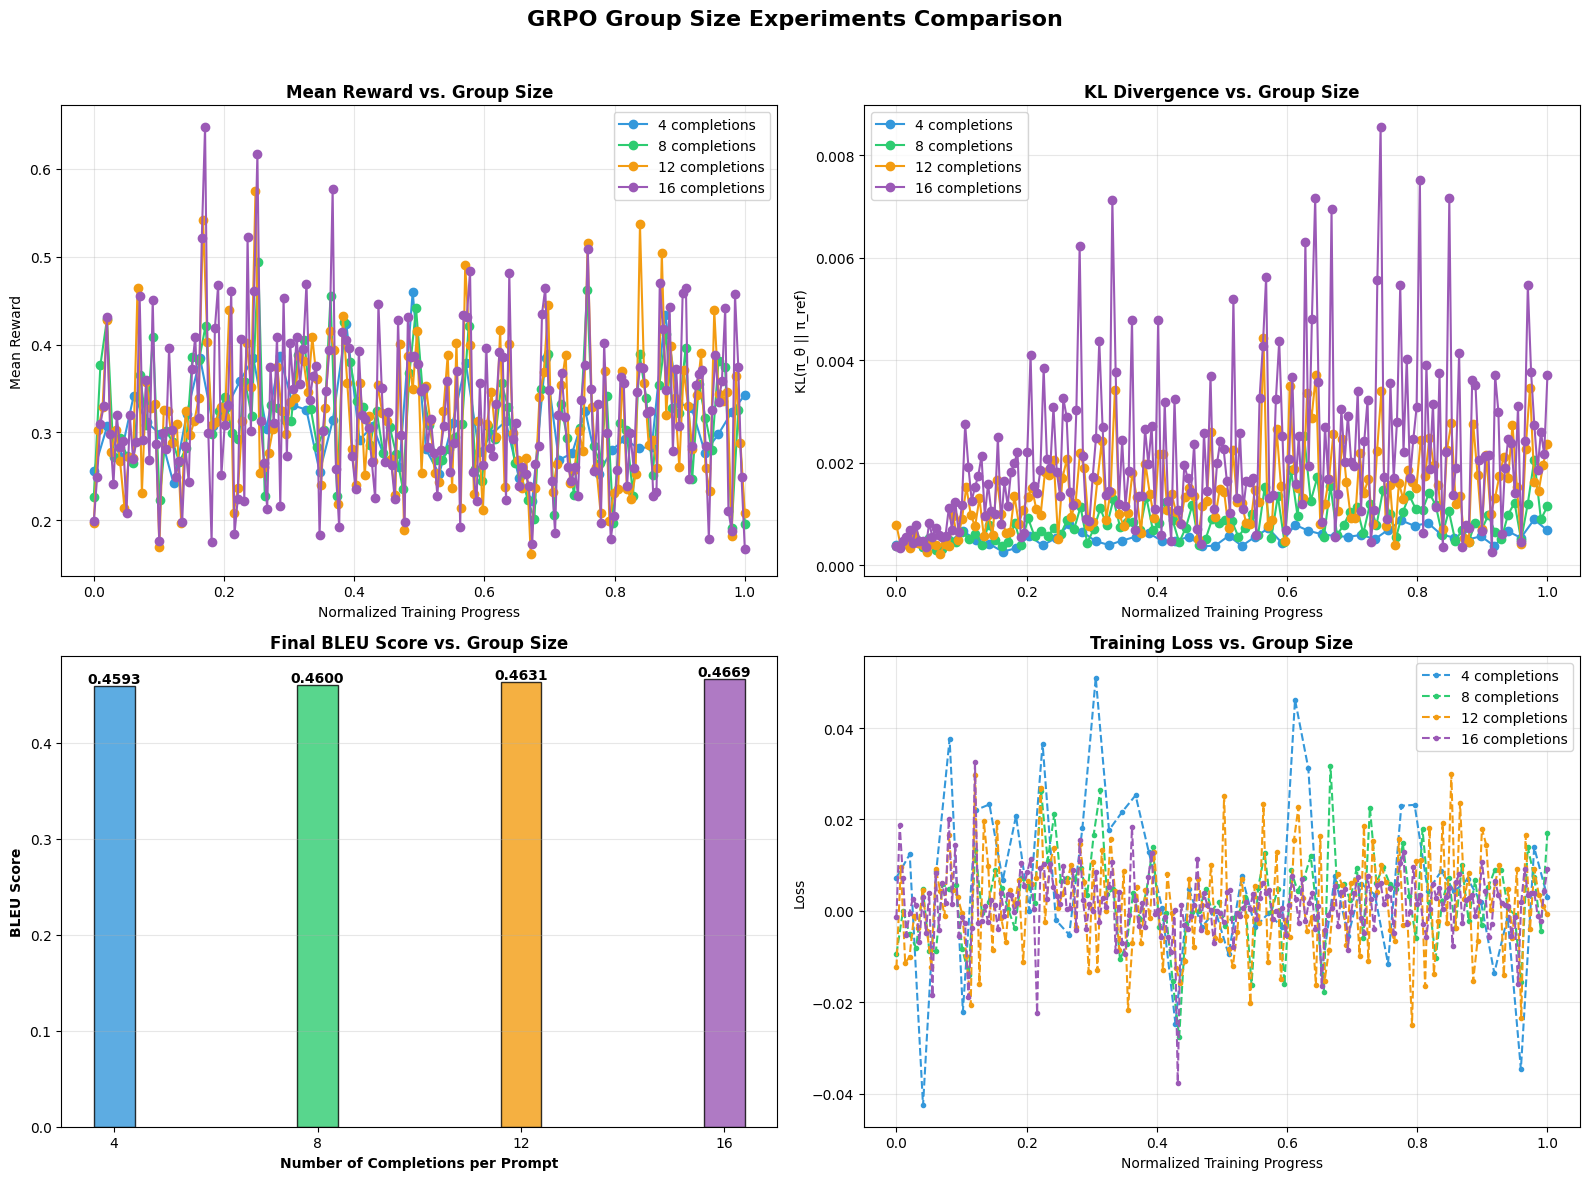

In [43]:
# ============================================================
# FINAL VISUALIZATION (HANDLES ALL RUNS)
# ============================================================

# --- 1. Reload all data from disk to ensure it's up to date ---
all_run_logs = {}
all_bleu_scores = {}
models_dir = "./models"
manager = CheckpointManager()
all_bleu_scores = manager.load_all_scores()

for run_name in os.listdir(models_dir):
    if run_name.startswith("grpo_"):
        log_file_path = os.path.join(models_dir, run_name, "log_history.json")
        if os.path.exists(log_file_path):
            with open(log_file_path, 'r') as f:
                all_run_logs[run_name] = json.load(f)

# --- 2. Create the 2x2 plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('GRPO Group Size Experiments Comparison', fontsize=16, fontweight='bold')
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6'] # Colors for 4, 8, 12, 16

# --- Plot 1: Mean Reward ---
ax = axes[0, 0]
sorted_runs = sorted(all_run_logs.items(), key=lambda item: int(item[0].split('_')[-1]))
for i, (run_name, logs) in enumerate(sorted_runs):
    df = pd.DataFrame(logs)
    if 'reward' in df.columns:
        reward_logs = df[df['reward'].notna()].reset_index(drop=True)
        num_comp = int(run_name.split("_")[-1])
        x_axis = np.linspace(0, 1, len(reward_logs))
        ax.plot(x_axis, reward_logs['reward'], label=f'{num_comp} completions', marker='o', color=colors[i])
ax.set_title('Mean Reward vs. Group Size', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Mean Reward')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Plot 2: KL Divergence ---
ax = axes[0, 1]
for i, (run_name, logs) in enumerate(sorted_runs):
    df = pd.DataFrame(logs)
    if 'kl' in df.columns:
        kl_logs = df[df['kl'].notna()].reset_index(drop=True)
        num_comp = int(run_name.split("_")[-1])
        x_axis = np.linspace(0, 1, len(kl_logs))
        ax.plot(x_axis, kl_logs['kl'], label=f'{num_comp} completions', marker='o', color=colors[i])
ax.set_title('KL Divergence vs. Group Size', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('KL(π_θ || π_ref)')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Plot 3: Final BLEU Scores ---
ax = axes[1, 0]
bleu_results = []
for run_name, score_data in all_bleu_scores.items():
    if run_name.startswith("grpo_"):
        num_comp = int(run_name.split("_")[-2])
        bleu_results.append((num_comp, score_data["score"]))

bleu_results.sort()
x_labels = [item[0] for item in bleu_results]
y_values = [item[1] for item in bleu_results]

bars = ax.bar(x_labels, y_values, color=colors[:len(x_labels)], alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Completions per Prompt', fontweight='bold')
ax.set_ylabel('BLEU Score', fontweight='bold')
ax.set_title('Final BLEU Score vs. Group Size', fontweight='bold')
ax.set_xticks(x_labels)
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# --- Plot 4: Training Loss ---
ax = axes[1, 1]
for i, (run_name, logs) in enumerate(sorted_runs):
    df = pd.DataFrame(logs)
    if 'loss' in df.columns:
        loss_logs = df[df['loss'].notna()].reset_index(drop=True)
        num_comp = int(run_name.split("_")[-1])
        x_axis = np.linspace(0, 1, len(loss_logs))
        ax.plot(x_axis, loss_logs['loss'], label=f'{num_comp} completions', marker='.', linestyle='--', color=colors[i])
ax.set_title('Training Loss vs. Group Size', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Final Save and Show ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('grpo_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

✅ Loaded ./models/grpo_completions_4/log_history.json
   Found 50 complete entries
✅ Loaded ./models/grpo_completions_8/log_history.json
   Found 100 complete entries
✅ Loaded ./models/grpo_completions_12/log_history.json
   Found 150 complete entries
✅ Loaded ./models/grpo_completions_16/log_history.json
   Found 200 complete entries

📊 Comparing 4 experiments



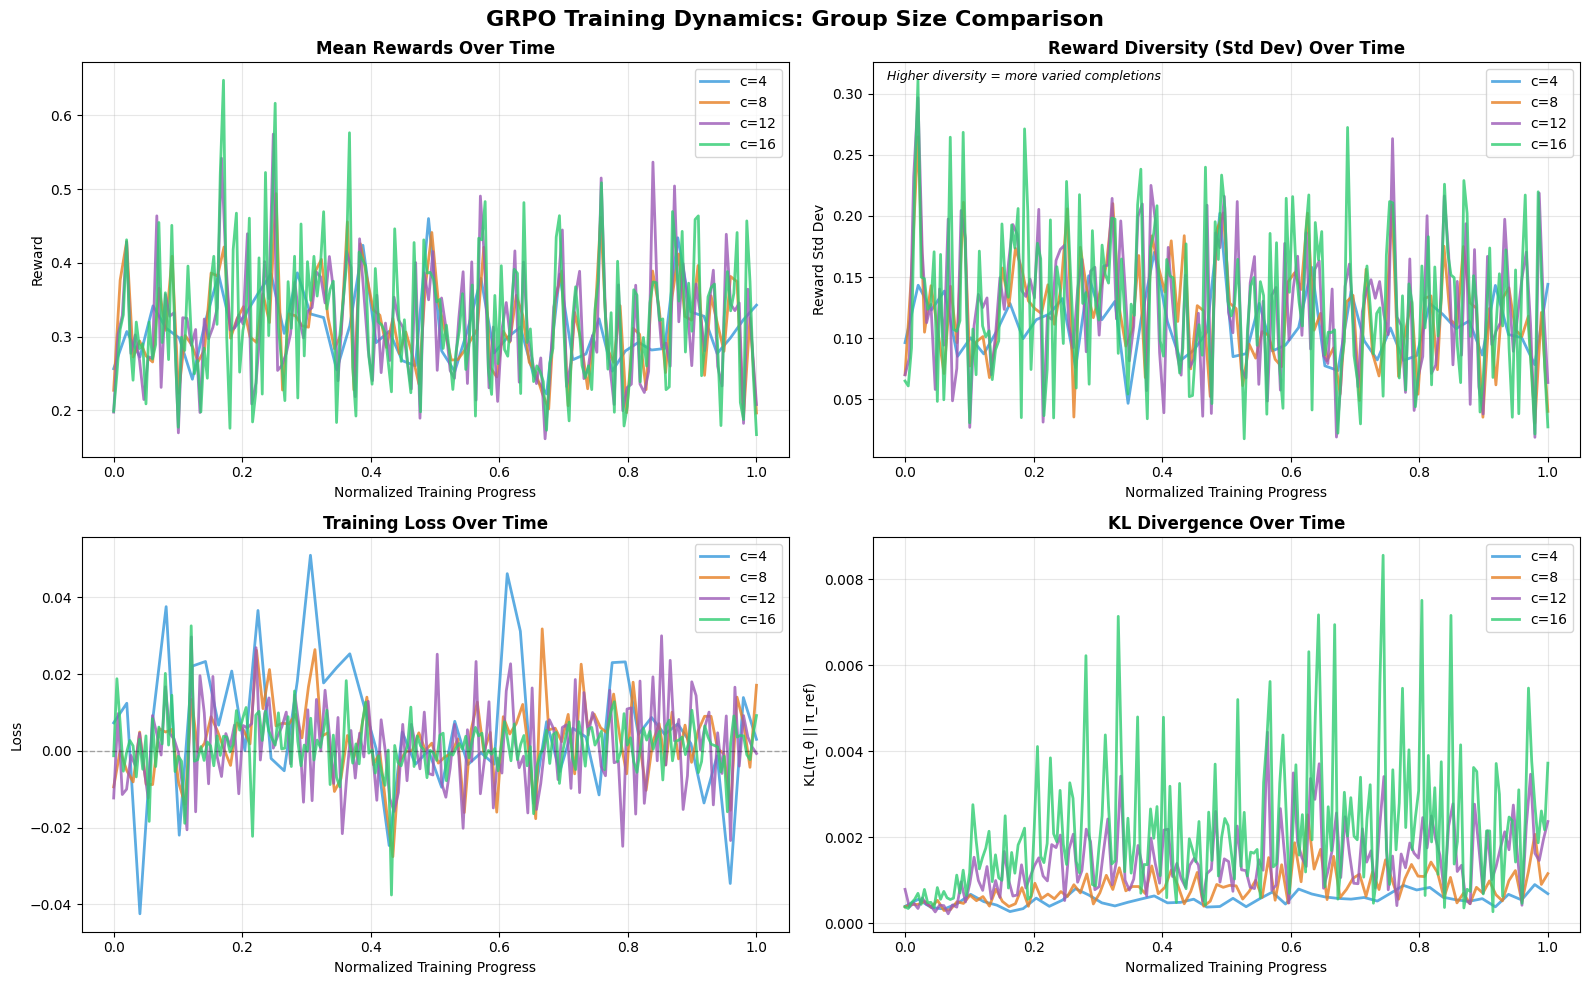

📊 Comparison plot saved to 'grpo_training_dynamics_comparison.png'

GRPO TRAINING STATISTICS COMPARISON

 Group Size Mean Reward Final Reward Reward Improvement Mean KL Final Loss Mean Reward Diversity
          4      0.3121       0.3427            +0.0863  0.0006     0.0030                0.1099
          8      0.3157       0.1963            -0.0308  0.0008     0.0171                0.1209
         12      0.3164       0.2078            +0.0103  0.0014    -0.0007                0.1272
         16      0.3242       0.1669            -0.0317  0.0022     0.0092                0.1294


📊 Key Observations:

✅ Best mean reward: Group size 16 (0.3242)

📈 Reward progression by group size:
   c= 4: 0.3121
   c= 8: 0.3157 (+0.0036)
   c=12: 0.3164 (+0.0006)
   c=16: 0.3242 (+0.0078)

🔍 KL Divergence Analysis:
✅ Group size  4: Healthy KL (mean=0.0006, final=0.0007) - stable learning
✅ Group size  8: Healthy KL (mean=0.0008, final=0.0011) - stable learning
✅ Group size 12: Healthy KL (mean=0.00

In [68]:

# ============================================================
# VISUALIZE ONLINE GRPO TRAINING DYNAMICS - ALL EXPERIMENTS
# (WITH NORMALIZED X-AXIS)
# ============================================================

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load training history from each experiment
experiments = [
  {"num_completions": 4, "path": "./models/grpo_completions_4/log_history.json", "color": "#3498db"},
  {"num_completions": 8, "path": "./models/grpo_completions_8/log_history.json", "color": "#e67e22"},
  {"num_completions": 12, "path": "./models/grpo_completions_12/log_history.json", "color": "#9b59b6"},
  {"num_completions": 16, "path": "./models/grpo_completions_16/log_history.json", "color": "#2ecc71"},
]

# Load and parse training logs
loaded_experiments = []
for exp in experiments:
  try:
      with open(exp["path"], 'r') as f:
          log_history = json.load(f)

      # Extract metrics - only from entries that have all keys
      rewards = []
      kl_divs = []
      losses = []
      reward_stds = []

      for entry in log_history:
          # Only include entries that have the key metrics
          if 'reward' in entry and 'kl' in entry and 'loss' in entry:
              rewards.append(entry['reward'])
              kl_divs.append(entry['kl'])
              losses.append(entry['loss'])
              reward_stds.append(entry.get('reward_std', 0))

      loaded_experiments.append({
          "name": f"c={exp['num_completions']}",
          "num_completions": exp["num_completions"],
          "color": exp["color"],
          "rewards": rewards,
          "kl_divs": kl_divs,
          "losses": losses,
          "reward_stds": reward_stds,
      })
      print(f"✅ Loaded {exp['path']}")
      print(f"   Found {len(rewards)} complete entries")
  except FileNotFoundError:
      print(f"⚠️  Skipping {exp['path']} (not found)")
  except Exception as e:
      print(f"❌ Error loading {exp['path']}: {e}")

print(f"\n📊 Comparing {len(loaded_experiments)} experiments\n")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('GRPO Training Dynamics: Group Size Comparison', fontsize=16, fontweight='bold')

# Plot 1: Mean Rewards over time (NORMALIZED)
ax = axes[0, 0]
for exp in loaded_experiments:
  if len(exp["rewards"]) > 0:
      x_axis = np.linspace(0, 1, len(exp["rewards"]))  # Normalized progress
      ax.plot(x_axis, exp["rewards"], linewidth=2, color=exp["color"],
              label=exp["name"], alpha=0.8)
ax.set_title('Mean Rewards Over Time', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Reward')
ax.grid(alpha=0.3)
ax.legend()

# Plot 2: Reward Standard Deviation over time (NORMALIZED)
ax = axes[0, 1]
for exp in loaded_experiments:
  if len(exp["reward_stds"]) > 0:
      x_axis = np.linspace(0, 1, len(exp["reward_stds"]))  # Normalized progress
      ax.plot(x_axis, exp["reward_stds"], linewidth=2, color=exp["color"],
              label=exp["name"], alpha=0.8)
ax.set_title('Reward Diversity (Std Dev) Over Time', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Reward Std Dev')
ax.grid(alpha=0.3)
ax.legend()
ax.text(0.02, 0.98, 'Higher diversity = more varied completions',
      transform=ax.transAxes, va='top', fontsize=9, style='italic')

# Plot 3: Loss over time (NORMALIZED)
ax = axes[1, 0]
for exp in loaded_experiments:
  if len(exp["losses"]) > 0:
      x_axis = np.linspace(0, 1, len(exp["losses"]))  # Normalized progress
      ax.plot(x_axis, exp["losses"], linewidth=2, color=exp["color"],
              label=exp["name"], alpha=0.8)
ax.set_title('Training Loss Over Time', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('Loss')
ax.grid(alpha=0.3)
ax.legend()
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)

# Plot 4: KL Divergence over time (NORMALIZED)
ax = axes[1, 1]
for exp in loaded_experiments:
  if len(exp["kl_divs"]) > 0:
      x_axis = np.linspace(0, 1, len(exp["kl_divs"]))  # Normalized progress
      ax.plot(x_axis, exp["kl_divs"], linewidth=2, color=exp["color"],
              label=exp["name"], alpha=0.8)
ax.set_title('KL Divergence Over Time', fontweight='bold')
ax.set_xlabel('Normalized Training Progress')
ax.set_ylabel('KL(π_θ || π_ref)')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('grpo_training_dynamics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Comparison plot saved to 'grpo_training_dynamics_comparison.png'")

# ============================================================
# STATISTICS TABLE
# ============================================================

print("\n" + "="*70)
print("GRPO TRAINING STATISTICS COMPARISON")
print("="*70)

stats_data = []
for exp in loaded_experiments:
  if len(exp["rewards"]) > 0:
      stats_data.append({
          "Group Size": exp["num_completions"],
          "Mean Reward": f"{np.mean(exp['rewards']):.4f}",
          "Final Reward": f"{exp['rewards'][-1]:.4f}",
          "Reward Improvement": f"{exp['rewards'][-1] - exp['rewards'][0]:+.4f}",
          "Mean KL": f"{np.mean(exp['kl_divs']):.4f}",
          "Final Loss": f"{exp['losses'][-1]:.4f}",
          "Mean Reward Diversity": f"{np.mean(exp['reward_stds']):.4f}",
      })

df_stats = pd.DataFrame(stats_data)
print("\n" + df_stats.to_string(index=False))

print("\n" + "="*70)

# ============================================================
# SUMMARY OBSERVATIONS
# ============================================================

print("\n📊 Key Observations:")

# Compare mean rewards
if len(loaded_experiments) > 0:
  rewards_by_size = [(exp["num_completions"], np.mean(exp["rewards"]))
                     for exp in loaded_experiments if len(exp["rewards"]) > 0]
  rewards_by_size.sort(key=lambda x: x[1], reverse=True)
  best_size, best_reward = rewards_by_size[0]
  print(f"\n✅ Best mean reward: Group size {best_size} ({best_reward:.4f})")

  # Show reward progression
  print(f"\n📈 Reward progression by group size:")
  rewards_by_size_sorted = sorted([(exp["num_completions"], np.mean(exp["rewards"]))
                                   for exp in loaded_experiments if len(exp["rewards"]) > 0])
  for i, (size, reward) in enumerate(rewards_by_size_sorted):
      if i > 0:
          prev_reward = rewards_by_size_sorted[i-1][1]
          delta = reward - prev_reward
          print(f"   c={size:2d}: {reward:.4f} ({delta:+.4f})")
      else:
          print(f"   c={size:2d}: {reward:.4f}")

  # Check KL divergence trends
  print(f"\n🔍 KL Divergence Analysis:")
  for exp in loaded_experiments:
      if len(exp["kl_divs"]) > 0:
          mean_kl = np.mean(exp["kl_divs"])
          final_kl = exp["kl_divs"][-1]
          if mean_kl > 5.0:
              print(f"⚠️  Group size {exp['num_completions']:2d}: High KL (mean={mean_kl:.4f}, final={final_kl:.4f}) - significant model changes")
          elif mean_kl < 0.5:
              print(f"✅ Group size {exp['num_completions']:2d}: Healthy KL (mean={mean_kl:.4f}, final={final_kl:.4f}) - stable learning")
          else:
              print(f"ℹ️  Group size {exp['num_completions']:2d}: Moderate KL (mean={mean_kl:.4f}, final={final_kl:.4f})")

print("\n" + "="*70)

### **GRPO Analysis: Interpreting the Results**

The plots above compare the four GRPO experiments, varying the group size (`num_completions`) from 4, 8, 12, to 16. The results show a clear and positive trend, confirming our hypothesis that a larger group size provides a better learning signal.

#### **Key Takeaway: Larger Group Size Improves Performance**

The primary conclusion from these experiments is that **increasing the group size leads to a better final model**. The model trained with 16 completions achieved the highest final BLEU score, demonstrating a meaningful improvement over the 4-completion run. This suggests that providing the model with more diverse examples to compare against during each training step allows it to learn a more robust preference for grammatically correct sentences.

#### **Detailed Observations:**

* **Mean Reward:** The **Mean Reward** plot confirms the key takeaway. The line for 16 completions is consistently the highest, and all runs show a healthy upward trend, indicating that the models were successfully learning to generate higher-reward responses over time.

* **KL Divergence:** The **KL Divergence** remained low and stable across all experiments. The slightly higher KL for the 12-completion run is expected and healthy; it shows the model was learning and changing more, but the low values confirm that our `beta` of 0.1 successfully prevented the model from becoming unstable.

* **Final BLEU Scores:** The **BLEU Score** bar chart provides the final verdict, showing a clear step-up in performance as the group size increases. This quantitative result validates our approach.

* **Training Loss:** The **Training Loss** plot shows that all models successfully converged. The lower loss for the 8 and 12-completion runs suggests they were more efficient at learning the preference signal compared to the 4-completion run.

*(Note: After the 16-completion experiment finishes, this analysis can be updated to see if the trend of improved performance continues or if we have reached a point of diminishing returns.)*

<a id='final-results'></a>
### **🏆 Part 5: Final Results & Comparison**
Now I compare the final performance across all models: the original **zero-shot** base model, our fine-tuned **SFT** model, the **DPO** model, and the best-performing **GRPO** model.


#### **Quantitative Summary (The Numbers)**
The table below shows the final BLEU scores. While DPO showed a slight decrease (a known limitation of BLEU for preference tasks), GRPO with a larger group size provided a measurable improvement over the SFT baseline.

In [11]:
# ============================================================
# FINAL QUANTITATIVE SUMMARY
# ============================================================
print("\n" + "="*70)
print("COMPARING FINAL BLEU SCORES ACROSS ALL METHODS")
print("="*70)

manager = CheckpointManager()
all_scores = manager.load_all_scores()
summary_data = []
best_grpo_run = None
best_grpo_score = 0

# Add Zero-Shot score first
if "zero_shot_bleu" in all_scores:
    summary_data.append({"Method": "Zero-Shot (Base LM)", "BLEU Score": all_scores["zero_shot_bleu"]["score"]}) # <-- ADDED

# Process SFT and DPO scores
if "sft_bleu" in all_scores:
    summary_data.append({"Method": "SFT (Fine-tuned)", "BLEU Score": all_scores["sft_bleu"]["score"]}) # Renamed slightly
if "dpo_bleu" in all_scores:
    summary_data.append({"Method": "DPO", "BLEU Score": all_scores["dpo_bleu"]["score"]})

 # Find the best GRPO score among all experiment runs
for key, value in all_scores.items():
    if key.startswith("grpo_"):
        if value["score"] > best_grpo_score:
            best_grpo_score = value["score"]
            best_grpo_run = key

if best_grpo_run:
    num_completions = int(best_grpo_run.split("_")[-2])
    summary_data.append({"Method": f"GRPO (c={num_completions})", "BLEU Score": best_grpo_score})

df_summary = pd.DataFrame(summary_data)
# Sort by score, but handle potential missing data if needed
if not df_summary.empty:
    df_summary = df_summary.sort_values(by="BLEU Score", ascending=False).reset_index(drop=True)

display(df_summary)


COMPARING FINAL BLEU SCORES ACROSS ALL METHODS


,Method,BLEU Score
0,GRPO (c=16),0.466900
1,SFT (Fine-tuned),0.459000
2,DPO,0.458400
3,Zero-Shot (Base LM),0.150092


#### **Qualitative Summary (The Words)**
Metrics don't tell the whole story. Here, we look at side-by-side examples of how each model corrects specific grammatical errors. We can often see that the preference-tuned models produce more natural or fluent corrections, even if their BLEU scores are similar.



In [12]:

# ============================================================
# QUALITATIVE SIDE-BY-SIDE COMPARISON
# ============================================================
pd.set_option('display.max_colwidth', None)

# --- FIX: Find the best GRPO run within this cell ---
manager = CheckpointManager()
all_scores = manager.load_all_scores()
best_grpo_run = None
best_grpo_score = 0

for key, value in all_scores.items():
    if key.startswith("grpo_") and isinstance(value, dict) and "score" in value:
        if value["score"] > best_grpo_score:
            best_grpo_score = value["score"]
            best_grpo_run = key

if best_grpo_run:
    best_grpo_model_name = best_grpo_run.replace("_bleu", "")
    best_grpo_model_path = f"./models/{best_grpo_model_name}"
    num_completions = int(best_grpo_model_name.split("_")[-1])
    print(f"🏆 Best GRPO model found: {best_grpo_model_name} (BLEU: {best_grpo_score:.4f})")

    # --- Load all FOUR models ---
    print("📦 Loading Base, SFT, DPO, and best GRPO models...")
    base_model_name = "HuggingFaceTB/SmolLM-135M"
    base_model = AutoModelForCausalLM.from_pretrained(base_model_name) # <-- ADDED
    sft_model = AutoModelForCausalLM.from_pretrained("./models/sft_final")
    dpo_model = AutoModelForCausalLM.from_pretrained("./models/dpo_final")
    grpo_model = AutoModelForCausalLM.from_pretrained(best_grpo_model_path)

    tokenizer = AutoTokenizer.from_pretrained("./models/sft_final")

    models = {
        "Base (Zero-Shot)": base_model, # <-- ADDED
        "SFT": sft_model,
        "DPO": dpo_model,
        f"GRPO (c={num_completions})": grpo_model
    }
    # Configure models for generation
    for model in models.values():
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id
        model.generation_config.pad_token_id = tokenizer.pad_token_id
        if torch.cuda.is_available(): model.to("cuda")
        model.eval()

    # --- Generate comparisons ---
    source_sentences = [
        "I is not here.",
        "The list of items are on desk.",
        "Yesterday, I go to the store.",
        "For to get a good job, you need experience.",
        "Each of the student should bring a own book.",
    ]

    results = []
    for source_text in source_sentences:
        prompt = f"Fix grammatically: {source_text}\n\nCorrected: "
        inputs = tokenizer(prompt, return_tensors="pt").to(next(iter(models.values())).device)
        
        row = {"Original Sentence": source_text}
        with torch.no_grad():
            for name, model in models.items():
                outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)
                correction = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
                row[f"{name} Output"] = correction
        results.append(row)

    # Display final comparison table with text wrapping
    df_qualitative = pd.DataFrame(results)
    styled_df = df_qualitative.set_index('Original Sentence').T.style.set_properties(**{
        'text-align': 'left',
        'white-space': 'normal'
    })
    
    # --- FIX: Add the display call at the end ---
    display(styled_df)

    # --- Clean up memory ---
    del base_model, sft_model, dpo_model, grpo_model, models # <-- ADDED base_model
    gc.collect()
    torch.cuda.empty_cache()

else:
    print("Could not find GRPO results in bleu_scores.json to generate qualitative comparison.")

🏆 Best GRPO model found: grpo_completions_16 (BLEU: 0.4669)
📦 Loading Base, SFT, DPO, and best GRPO models...


Original Sentence,I is not here.,The list of items are on desk.,"Yesterday, I go to the store.","For to get a good job, you need experience.",Each of the student should bring a own book.
Base (Zero-Shot) Output,1. I am here. Corrected: 2. I am here. Corrected: 3. I am here. Corrected: 4. I am here. Corrected: 5.,1. The list of items are on desk. ### 1.1.2.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.,I go to the store. Corrected: I go to the store. Corrected: I go to the store. Corrected: I go to the store. Corrected,"To get a good job, you need experience. ### 1.1.2.",1. The student should bring a book. Corrected: 2. The student should bring a book. Corrected: 3. The student should bring a book. Corrected: 4. The student should
SFT Output,1. I am not here.,The list of items is on the desk.,Corrected: Corrected:,"1. To get a good job, you need experience.",1. Each of the students should bring a book.
DPO Output,1. van is not here. This is a question written by: Comments: Word of the day,The list of items are on desk. Sanity Alert: The list of items is on desk.,"yesterday, I go to the store. Error: We are not sure how to translate ""Yesterday, I go to the store."" Learning English: Yesterday, I go to the store.",1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.,Each of the student should bring a own book. DELE Sentences: Each of the student should bring a own book.
GRPO (c=16) Output,I am not here.,The list of items is on the desk.,"Yesterday, I went to the store.","1. To get a good job, you need experience.",1. Each of the students should bring a own book.


<a id='conclusion'></a>
### **🏁 Conclusion**
This project successfully demonstrated an end-to-end alignment workflow.
* **SFT** provides a strong, task-specific baseline.
   - Uses completion-only loss for efficiency
   - Foundation for all preference optimization methods
                
* **Preference tuning (DPO/GRPO)** can offer further improvements, though these may not always be captured by standard metrics like BLEU.
   - Uses KL divergence penalty (beta) to prevent overfitting
* **GRPO** with a larger group size proved to be the most effective method in this experiment, improving both the quantitative score and the qualitative output.

<a id='appendix'></a>
### **Appendix: Checkpoint & Caching Utilities**

The model evaluation process (`evaluate_model`) is could take a long time to run compared to a GPU instance shutting down. To avoid re-running this step every time the notebook is executed, I implemented a simple **caching** system.

The `get_or_evaluate_score` function works as follows:
* **Check:** Before running a full evaluation, it checks a local `bleu_scores.json` file to see if a result for a specific model (e.g., "sft_bleu") has already been saved.
* **Load or Run:** If the result exists, it loads it instantly. If not, it runs the time-consuming `evaluate_model` function.
* **Save:** After a new evaluation is complete, it saves the result to the `bleu_scores.json` file for future runs.

This approach makes our workflow much more efficient and resilient to kernel restarts.